# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/CVAE_ex2/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_types[0]}_features.pkl')
#dataloaders_dict = modeler.make_dataloader(ext_data)

In [9]:
#for sample in dataloaders_dict['train']:
#    hoge = sample['features']

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-04-24 13:21:54,927 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-04-24 13:21:54,928 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-24 13:21:54,969 - 00_train.py - INFO - TRAINING


use: cuda:0


2021-04-24 13:21:56,616 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
2021-04-24 13:21:57,511 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
2021-04-24 13:21:57,652 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


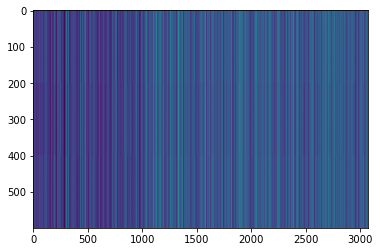

,AUC,pAUC
Source_0,0.473600,0.485263
Source_1,0.536200,0.496316
Source_2,0.568600,0.552105
Target_0,0.462400,0.496316
Target_1,0.501850,0.498947
Target_2,0.503500,0.487895
mean,0.507692,0.502807
h_mean,0.505198,0.501860


2021-04-24 13:21:58,623 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:15.575462, val_AUC_hmean:0.505198, val_pAUC_hmean:0.501860, best_flag:True
2021-04-24 13:21:58,624 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.41it/s]
2021-04-24 13:21:59,080 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
2021-04-24 13:21:59,210 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
2021-04-24 13:21:59,343 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:5.041064, val_AUC_hmean:0.435118, val_pAUC_hmean:0.477428, best_flag:False
2021-04-24 13:21:59,344 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.40it/s]
2021-04-24 13:21:59,716 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.93it/s]
2021-04-24 13:21:59,853 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  9.05it/s]
2021-04-24 13:21:59,990 - 

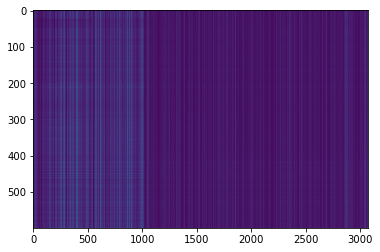

,AUC,pAUC
Source_0,0.452100,0.473684
Source_1,0.609900,0.525789
Source_2,0.441900,0.493684
Target_0,0.471700,0.492105
Target_1,0.661000,0.586842
Target_2,0.424900,0.482105
mean,0.510250,0.509035
h_mean,0.495834,0.506374


2021-04-24 13:22:06,947 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:0.520500, val_AUC_hmean:0.495834, val_pAUC_hmean:0.506374, best_flag:True
2021-04-24 13:22:06,948 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.96it/s]
2021-04-24 13:22:07,354 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
2021-04-24 13:22:07,487 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


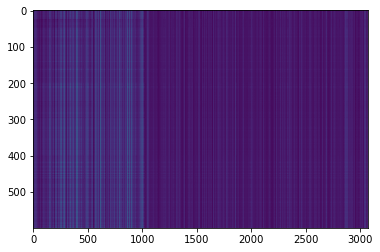

,AUC,pAUC
Source_0,0.514000,0.492632
Source_1,0.620700,0.535263
Source_2,0.499800,0.497895
Target_0,0.512200,0.517368
Target_1,0.708700,0.622632
Target_2,0.454800,0.488421
mean,0.551700,0.525702
h_mean,0.539589,0.522058


2021-04-24 13:22:08,566 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:0.473331, val_AUC_hmean:0.539589, val_pAUC_hmean:0.522058, best_flag:True
2021-04-24 13:22:08,567 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.98it/s]
2021-04-24 13:22:08,971 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.82it/s]
2021-04-24 13:22:09,105 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


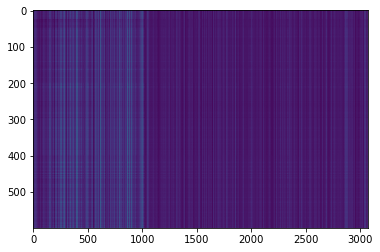

,AUC,pAUC
Source_0,0.587700,0.513158
Source_1,0.617200,0.542105
Source_2,0.583700,0.532632
Target_0,0.562000,0.540526
Target_1,0.736500,0.640526
Target_2,0.484600,0.504211
mean,0.595283,0.545526
h_mean,0.586185,0.542230


2021-04-24 13:22:10,087 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:0.445741, val_AUC_hmean:0.586185, val_pAUC_hmean:0.542230, best_flag:True
2021-04-24 13:22:10,088 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.51it/s]
2021-04-24 13:22:10,453 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.41it/s]
2021-04-24 13:22:10,596 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
2021-04-24 13:22:10,754 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:0.424870, val_AUC_hmean:0.582524, val_pAUC_hmean:0.534197, best_flag:False
2021-04-24 13:22:10,756 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-24 13:22:11,150 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.71it/s]
2021-04-24 13:22:11,287 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
2021-04-24 13:22:11,427 -

100%|██████████| 1/1 [00:00<00:00,  7.65it/s]
2021-04-24 13:22:21,477 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:0.297964, val_AUC_hmean:0.506733, val_pAUC_hmean:0.494834, best_flag:False
2021-04-24 13:22:21,478 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
2021-04-24 13:22:21,896 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
2021-04-24 13:22:22,045 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
2021-04-24 13:22:22,177 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:0.294916, val_AUC_hmean:0.523273, val_pAUC_hmean:0.497416, best_flag:False
2021-04-24 13:22:22,178 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-24 13:22:22,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
2021-04-24 13:22:22,712 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00

100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
2021-04-24 13:22:32,887 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  8.18it/s]
2021-04-24 13:22:33,034 - pytorch_modeler.py - INFO - epoch:48/300, train_losses:0.255305, val_AUC_hmean:0.568372, val_pAUC_hmean:0.506033, best_flag:False
2021-04-24 13:22:33,035 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]
2021-04-24 13:22:33,422 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  8.83it/s]
2021-04-24 13:22:33,557 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  8.49it/s]
2021-04-24 13:22:33,699 - pytorch_modeler.py - INFO - epoch:49/300, train_losses:0.253105, val_AUC_hmean:0.568153, val_pAUC_hmean:0.503660, best_flag:False
2021-04-24 13:22:33,700 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]
2021-04-24 13:22:34,087 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00

KeyboardInterrupt: 

In [12]:
for machine_type in machine_types:
    run(machine_type)